In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
# from train_bbnet import get_args, load_model
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def zscore(x, eps=1e-6):
    m = x.mean((-2,-1), True)
    s = x.std((-2,-1), True)
    return (x - m) / s.clamp(min=eps)

def get_patches(im, radius=1):
    if radius == 0:
        return im
    shape = im.shape
    if len(shape) == 5:
        im = im.view(shape[0]*shape[1], *shape[2:])
    B,C,H,W = im.shape
    
    im = F.pad(im, (radius, radius, radius, radius))
    k = 2*radius+1
    im = F.unfold(im, (k, k)).view(-1,C*(k**2),H,W)
    if len(shape) == 5:
        im = im.view(shape[0], shape[1], *im.shape[1:])
    return im    
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = (aff_node.shape[-1] - 1) // 2
#     aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,(K+1):]], 1)        
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False, is_test=False, sigmoid=True):
    dataset.is_test = is_test
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = (nn.Sigmoid() if sigmoid else nn.Identity())(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  
    

def viz_boundary_preds(b_preds, thresh=0.1, max_speed=0.1, do_plot=True):
    motion = None
    if b_preds.shape[1] == 9:
        c1_preds, b_preds, c2_preds = b_preds.split([4,1,4], dim=-3)
        c_preds = torch.cat([c1_preds, c2_preds], -3).softmax(-3)
        c_preds_rgb = fprop.circular_target_to_spatial_moment(c_preds)
    elif b_preds.shape[1] == 3:
        b_preds, c_preds = b_preds.split([1,2], dim=-3)
        c_preds_rgb = c_preds
    elif b_preds.shape[1] == 4:
        motion, b_preds, c_preds = b_preds.split([1,1,2], dim=-3)
        c_preds_rgb = c_preds
    b_preds = b_preds.sigmoid()
    if do_plot:
        vis_utils.imshow(data_utils.FlowToRgb(max_speed=max_speed)(c_preds_rgb) * (b_preds > thresh).float())    
    return (b_preds, c_preds, motion)


def get_boundary_preds(model, dataset, ex, static_input=True, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]
    if backward:
        ups_mask, b_preds = model(img2, img2 if static_input else img1, test_mode=True, iters=iters)
    else:
        ups_mask, b_preds = model(img1, img1 if static_input else img2, test_mode=True, iters=iters)
    return (b_preds, ups_mask)

def get_motion_preds(model, dataset, ex, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]    
    if backward:
        ups_mask, m_preds = model(img2, img2, test_mode=True, iters=iters)
    else:
        ups_mask, m_preds = model(img1, img2, test_mode=True, iters=iters)
    return (m_preds, ups_mask)

def get_boundary_movie(model, dataset, ex, iters=12, thresh=None):
    img1, img2, img0 = [x[None].cuda() for x in dataset[ex][:3]]
    b1 = model(img1, img1, test_mode=True, iters=12)[-1]
    b2 = model(img2, img2, test_mode=True, iters=12)[-1]
    b0 = model(img0, img0, test_mode=True, iters=12)[-1]
    b_movie = []
    for b in [b0, b1, b2]:
        b_preds, c_preds = viz_boundary_preds(b, do_plot=False)
        if thresh is not None:
            b_movie.append((b_preds > thresh).float() * c_preds)
        else:
            b_movie.append(b_preds * c_preds)
    return torch.stack(b_movie, 1)

def get_video(dataset, ex=0, stride=1):
    dataset.get_backward_frame = True
    data = dataset[ex]
    video = torch.stack([x.cuda() for x in [data[2], data[0], data[1]]], 0) / 255.
    size = list(video.shape[-2:])
    if stride > 1:
        video = transforms.Resize((size[0] // stride, size[1] // stride))(video)
    return video[None]


/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:555: DeprecationWarning: `np.object` is a d

In [4]:
def get_gt_motion_and_boundaries(dataset, ex, max_objects=8, radius=3):
    dataset.get_backward_frame = False
    dataset.get_gt_segments = True
    dataset.get_gt_flow = True    
    
    img1, img2, flow, segments = [x[None].cuda() for x in dataset[ex]]
    motion = (flow.abs().sum(1, True) > 0).float()
    obj_ids = torch.unique(segments)[:max_objects]
    masks = (segments == obj_ids.view(1, -1, 1, 1)).float()
    borders, _ = fprop.get_mask_boundaries(masks)
    masks, borders = masks[:,1:], borders[:,1:]
    size = masks.shape[-2:]
    orients = fprop.estimate_boundary_orientations(
        borders.view(-1, 1, *size),
        masks.view(-1, 1, *size),
        radius=radius,
        to_circle=False
    ).view(1, -1, 2, *size)
    return (img1, flow, motion, masks, borders, orients)

def mask_orientations(masks, boundaries, orientations):
    return (orientations * boundaries[:,:,None] * masks[:,:,None]).sum(1)

def get_adj_gt(masks, radius=3):
    masks = torch.cat([1-masks.amax(1, True), masks], -3)
    segments = masks.argmax(1, True)
    adj_gt = fprop.get_local_neighbors(
        segments, radius=radius, to_image=True, invalid=-1
    )[:,0] == segments
    return adj_gt.float()

def estimate_kp_adj(motion, boundaries, radius=3):
    r = radius
    k = 2*r + 1
    K = k**2
    null_idx = (K - 1) // 2
    B,_,H,W = motion.shape
    adj = F.one_hot(torch.tensor(null_idx), num_classes=K).to(motion.device)
    adj = adj.view(1,1,k,k).repeat(B*H*W, 1, 1, 1)
    mask = fprop.get_local_neighbors(motion, radius=r, invalid=0, to_image=True)[:,0]
    mask = mask.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    adj = adj * mask
    boundaries = fprop.get_local_neighbors(boundaries, radius=r, invalid=0, to_image=True)[:,0]
    b = boundaries.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    
#     u = 1 - adj
    kernel = torch.ones((3,3)).float().view(1,9,1,1).repeat(1,1,k,k).to(b.device)
    
    for it in range(r):
        adj_new = fprop.compute_local_effects(adj, kernel)
#         u = F.relu(u - fprop.compute_local_effects(adj.abs(), kernel))
        adj_new = adj_new * (1 - b) - adj_new.abs() * b
        adj = (adj + adj_new).clamp(min=-1, max=1) * mask        
    adj = F.relu(adj)
    adj = adj.view(B,H*W,K).permute(0,2,1).view(B,K,H,W)
    adj = torch.maximum(adj, boundaries) * motion
    return adj

import matplotlib
def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

# ex = 21
# _img, _flow, _motion, _masks, _borders, _orients = get_gt_motion_and_boundaries(tdw_dataset, ex)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(5)],
    split='validation',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)


data_dir = '/mnt/fs6/honglinc/dataset/tensorflow_datasets/movi_d/256x256/1.0.0'
movi_dataset = raft_datasets.MoviFlowDataset(
    root=data_dir,
    split='validation',
    sequence_length=2
)
print(len(movi_dataset))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


625
True


/home/dbear/tenv/lib/python3.7/site-packages/tensorflow/python/ops/numpy_ops/np_random.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def randint(low, high=None, size=None, dtype=onp.int):  # pylint: disable=missing-function-docstring


250


# Look at TargetFunc outputs

In [7]:
# motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*nthr05*fullplay*pretrained*
# motion_paths = !ls ../checkpoints/[0-9]*motion*tdw*nthr0-cthr025*

motion_paths = !ls ../checkpoints/[0-9]*motion*rnd0*movi_d*bs2*large*gs1*
# motion_paths = !ls ../checkpoints/[0-9]*motion*rnd1*movi_d*bs2*gs1*
# motion_paths = !ls ../checkpoints/[0-9]*motion*rnd0*movi_d*bs2*small*gs1*

motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
1 ../checkpoints/2500_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1.pth
2 ../checkpoints/5000_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
3 ../checkpoints/7500_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
4 ../checkpoints/10000_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
5 ../checkpoints/12500_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
6 ../checkpoints/15000_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
7 ../checkpoints/17500_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
8 ../checkpoints/20000_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
9 ../checkpoints/22500_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
10 ../checkpoints/25000_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
11 ../checkpoints/27500_motion-rnd0-movi_d-bs2-large-dtarg-

In [8]:
# boundary_paths = !ls ../checkpoints/[0-9]*boundary*rnd1*dtarg*fullplay*pretrained*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*cthr075*fullplay*rerun*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotionReg*rnd0*small*nthr0*cthr075*fullplay*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotionReg*rnd1*tdw*small*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStatic*rnd0*movi_d*nthr0-*gs1*
boundary_paths = !ls ../checkpoints/100000*boundaryMotion*rnd0*movi_d*nthr0-*gs1*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotion*rnd1*movi_d*gs1*


boundary_paths = sorted(boundary_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
for i,p in enumerate(boundary_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/100000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-3.pth


In [9]:
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*bmt*movi_d*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd0*movi_d*gs1*
# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd1*movi_d*gs1*

flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*rnd0*movi_d*small*gs1*


# flow_paths = !ls ../checkpoints/[0-9]*flowBoundary*tdw*

flow_paths = sorted(flow_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(flow_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/2500_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
1 ../checkpoints/5000_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
2 ../checkpoints/7500_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
3 ../checkpoints/10000_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
4 ../checkpoints/12500_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
5 ../checkpoints/15000_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
6 ../checkpoints/17500_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
7 ../checkpoints/20000_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
8 ../checkpoints/22500_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
9 ../checkpoints/25000_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
10 ../checkpoints/27500_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
11 ../checkpoints/30000_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth
12 ../checkpoints

In [10]:
import teachers
m_idx = -1
b_idx = -1
f_idx = -1
m_path = motion_paths[m_idx]
b_path = boundary_paths[b_idx]
f_path = flow_paths[f_idx]
# f_path = None

TargetFunc = teachers.MotionToStaticTeacher(
    student_model_type=None,
    downsample_factor=2,
    spatial_resolution=4,
    motion_resolution=2,
    target_from_motion=False,
    return_intermediates=True,
    build_flow_target=True,
    motion_path=m_path,
    boundary_path=b_path,
    flow_path=f_path,
    motion_model_params={
        'small': 'small' in m_path,
        'gate_stride': 2 if ('gs1' not in m_path) else 1
    },
    boundary_model_params={
        'small': 'small' in b_path,
        'static_input': 'Static' in b_path,
        'orientation_type': 'regression',
        'gate_stride': 2 if ('gs1' not in b_path) else 1
    },
#     target_model_params={
#         'hp_params': None,
#     }
).cuda()
TargetFunc.eval()

def plot_targets(model, dataset, ex, motion_thresh=0.5, boundary_thresh=0.1, 
                 max_speed=1.0, flip_flow=False, **kwargs):
    img1, img2, flow, segments = [x[None].cuda() for x in dataset[ex]]
    model.target_model.motion_thresh = motion_thresh
    model.target_model.boundary_thresh = boundary_thresh
    targets = model(img1, img2, **kwargs)
    m_mask = (targets['motion'] > model.target_model.motion_thresh).float()
    b_mask = (targets['boundaries'] > model.target_model.boundary_thresh).float()
    
    model.target_model.FP.compute_kp_args = False
    fire = model.target_model.FP(
        motion=targets['motion'],
        boundaries=targets['boundaries'],
        orientations=targets['orientations'],
        adj=None
    )
    model.target_model.FP.compute_kp_args = True
    print(fire[0].shape)    
    targets['fire'] = fire
    
    fig, axes = plt.subplots(2,4,figsize=(16,8))
    n_r, n_c = len(axes[:,0]), len(axes[0])
    if flip_flow:
        targets['flow'] = torch.cat([
            targets['flow'][:,0:1], -targets['flow'][:,1:2]
        ], 1)
    else:
        flow = torch.cat([-flow[:,1:2], flow[:,0:1]], 1)
    plots = [
        img1 / 255.,
        targets['motion']*2 - 1,
        targets['boundaries']*2-1,
        data_utils.FlowToRgb(0.25)(targets['orientations'] * b_mask * m_mask),
#         targets['fire'] * 2 - 1,        
        data_utils.FlowToRgb(max_speed)(targets['flow']) if f_path is not None else (targets['fire']*2-1),
        targets['target'][:,None],
    ]
    cmaps = [None, 'inferno', 'RdBu_r', None, 'magma', 'twilight', None, 'twilight']
    print("target shape", plots[-1].shape)

    if flow is not None and (flow.shape[1] == 2):
        if flip_flow:
            plots.append(torch.tensor(flow_to_rgb(flow[0].cpu().permute(1,2,0).numpy())).permute(2,0,1)[None])
        else:
            plots.append(data_utils.FlowToRgb(50.)(flow))
        targets['flow_gt'] = flow
    else:
        plots.append(torch.zeros_like(targets['target'][None]))
        
    if segments is not None:
        plots.append(segments.long() - 1)
        targets['segments_gt'] = segments.long()
    else:
        plots.append(torch.zeros_like(targets['target'][None]))
        
    for i in range(n_r):
        for j in range(n_c):
            ax = axes[i][j]
            plot = plots[i*n_c + j]
            cmap = cmaps[i*n_c + j]
            vis_utils.imshow(plot, ax, cmap=cmap, vmin=-1, vmax=plot.amax()+(1 if cmap == 'twilight' else 0))
            ax.set_xticks([])
            ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    
    return targets

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier ../checkpoints/55000_motion-rnd0-movi_d-bs2-large-dtarg-nthr0-cthr025-pr1-gs1-0.pth
<All keys matched successfully> BoundaryClassifier ../checkpoints/100000_boundaryMotionReg-rnd0-movi_d-bs2-small-dtarg-nthr0-cthr075-pr1-gs1-3.pth
<All keys matched successfully> RAFT ../checkpoints/35000_flowBoundary-bmt-rnd0-movi_d-bs2-small-mt05-bt05-gs1-0.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


movie, frame b'5397' 0
flow edges
motion resolution 2
static x motion torch.Size([1, 64, 256, 256])
updated with fire torch.Size([1, 121, 128, 128])
updated with boundaries torch.Size([1, 121, 128, 128])
0 (tensor([ 0,  2,  3,  4, 18, 23], device='cuda:0'),)
1 (tensor([ 0,  2,  3,  4, 18, 21, 23], device='cuda:0'),)
HP time 0.8532099723815918
FP time 0.10595250129699707
KP time 0.10128903388977051
Comp time 0.5153436660766602
total time 1.5757951736450195
torch.Size([1, 256, 256])


target shape torch.Size([1, 1, 128, 128])


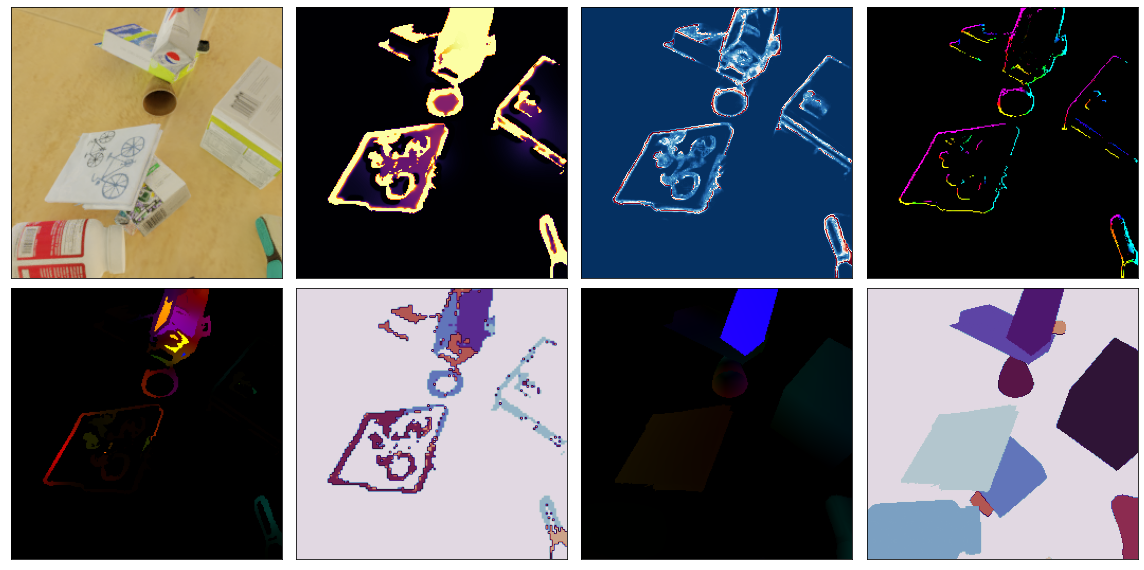

In [12]:
ex = 5099

tdw_dataset.is_test = False
tdw_dataset.get_gt_flow = True
tdw_dataset.get_gt_segments = True
tdw_dataset.get_backward_frame = False
movi_dataset.T = 2
dataset = movi_dataset
# dataset = tdw_dataset

targets = plot_targets(TargetFunc, dataset, ex=ex, max_speed=3.0,
                       motion_thresh=0.5, boundary_thresh=0.5, flip_flow=True,
                       flow_iters=24, bootstrap=True
                      )

In [12]:
import dorsalventral.evaluation.object_metrics as om
ari = om.adjusted_rand_index(
    pred_ids=(targets['target'][:,None]+1).long(),
    true_ids=targets['segments_gt'][...,::2,::2].long(),
    num_instances_pred=(targets['target']+1).amax().item()+1,
    num_instances_true=targets['segments_gt'].amax().item()+1,
    ignore_background=True
)
print(ari)

tensor([0.2700], device='cuda:0')


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Debug SpacetimeLocalKP

In [14]:
ex = 0
img1, img2 = [x[None].cuda() for x in movi_dataset[ex][:2]]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


movie, frame b'5397' 19


In [15]:
TargetFunc.student_model_type = None
TargetFunc.target_model.target_type = 'motion'
TargetFunc.return_intermediates = False

fwd = TargetFunc(img1, img2, bootstrap=True, flow_iters=24)
bck = TargetFunc(img2, img1, bootstrap=True, flow_iters=24)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


flow edges
flow edges


In [16]:
kp_args_fwd = TargetFunc.target_model.FP(
    motion=fwd['motion'],
    boundaries=fwd['boundaries'],
    orientations=fwd['orientations'],
    flow=fwd['flow']
)

kp_args_bck = TargetFunc.target_model.FP(
    motion=bck['motion'],
    boundaries=bck['boundaries'],
    orientations=bck['orientations'],
    flow=bck['flow']
)

motion resolution 2
static x motion torch.Size([1, 64, 256, 256])
updated with fire torch.Size([1, 121, 128, 128])
updated with boundaries torch.Size([1, 121, 128, 128])
motion resolution 2
static x motion torch.Size([1, 64, 256, 256])
updated with fire torch.Size([1, 121, 128, 128])
updated with boundaries torch.Size([1, 121, 128, 128])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


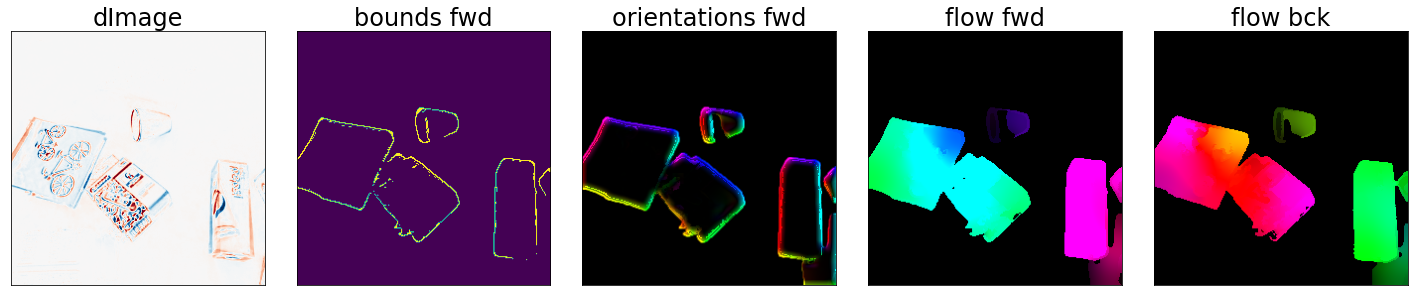

In [27]:
fig, axes = plt.subplots(1,5,figsize=(20,4))
vis_utils.imshow((img1.mean(1, True) - img2.mean(1, True)) / 255., axes[0], cmap='RdBu', vmin=-0.3, vmax=0.3)
vis_utils.imshow(fwd['boundaries'] > 0.5, axes[1])
vis_utils.imshow(data_utils.FlowToRgb(1.0)(fwd['orientations']), axes[2])
vis_utils.imshow(data_utils.FlowToRgb(3.0)(fwd['flow']), axes[3])
vis_utils.imshow(data_utils.FlowToRgb(3.0)(bck['flow']), axes[4])
titles = ['dImage', 'bounds fwd', 'orientations fwd', 'flow fwd', 'flow bck']
for i,ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=24)
plt.tight_layout()
plt.show()

In [18]:
SKP = fprop.SpacetimeLocalKProp(num_iters=50, 
                                radius_temporal=3, 
                                adj_temporal_thresh=None).cuda()
_stack = lambda z: torch.stack([z[0],z[1]], 1)
_ds = lambda x,s: F.avg_pool2d(x, s, stride=s) / s
kp_args = list(map(_stack, zip(kp_args_fwd, kp_args_bck)))

plateau = SKP(
    *[x.detach() for x in kp_args],
    fwd_flow=_ds(fwd['flow'], 2)[:,None].detach(),
    bck_flow=_ds(bck['flow'], 2)[:,None].detach()
)
print(plateau.shape)

plateau_t1 = SKP(
    *[x.detach()[:,0:1] for x in kp_args],
    fwd_flow=_ds(fwd['flow'], 2)[:,None].detach(),
    bck_flow=_ds(bck['flow'], 2)[:,None].detach()
)
print(plateau_t1.shape)

plateau_t2 = SKP(
    *[x.detach()[:,1:2] for x in kp_args],
    fwd_flow=_ds(fwd['flow'], 2)[:,None].detach(),
    bck_flow=_ds(bck['flow'], 2)[:,None].detach()
)
print(plateau_t2.shape)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])
f effects torch.Size([2, 64, 128, 128])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


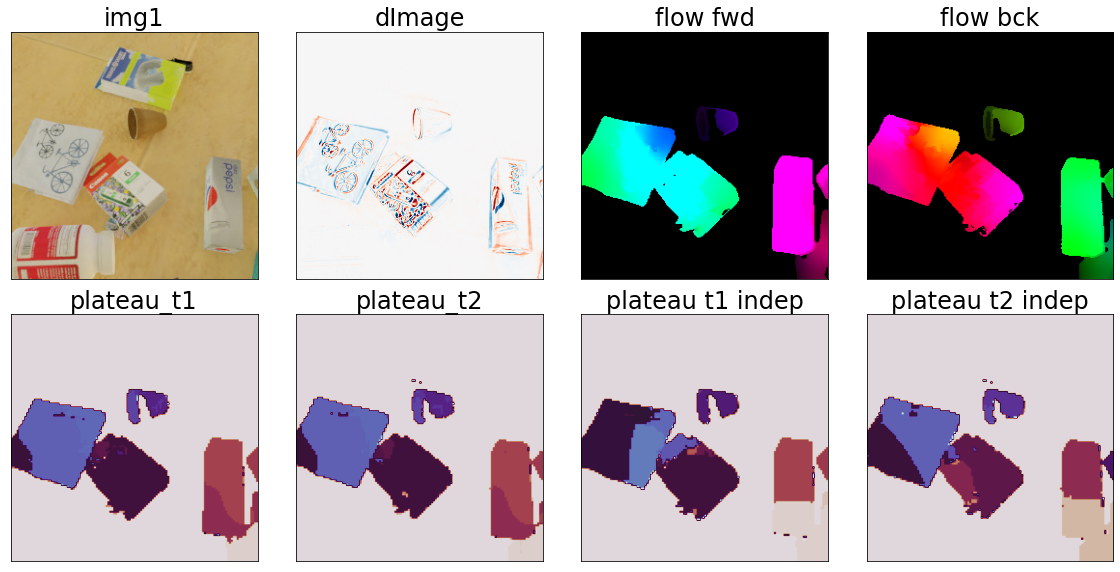

In [28]:
mask = (torch.stack([fwd['motion'], bck['motion']], 1) > 0.5).float().permute(0,1,3,4,2)[...,::2,::2,:]
plateau = torch.cat([plateau * mask, (1 - mask)], -1)
plateau_t1 = torch.cat([plateau_t1 * mask[:,0], (1 - mask[:,0])], -1)
plateau_t2 = torch.cat([plateau_t2 * mask[:,1], (1 - mask[:,1])], -1)

fig, axes = plt.subplots(2,4,figsize=(16,8))
vis_utils.imshow(img1 / 255., axes[0][0])
vis_utils.imshow((img1.mean(1, True) - img2.mean(1, True)) / 255., axes[0][1], cmap='RdBu', vmin=-0.3, vmax=0.3)
vis_utils.imshow(data_utils.FlowToRgb(3.0)(fwd['flow']), axes[0][2])
vis_utils.imshow(data_utils.FlowToRgb(3.0)(bck['flow']), axes[0][3])
vis_utils.imshow(plateau[:,0:1].argmax(-1), axes[1][0], cmap='twilight', vmin=0, vmax=plateau.argmax(-1).amax()+1)
vis_utils.imshow(plateau[:,1:2].argmax(-1), axes[1][1], cmap='twilight', vmin=0, vmax=plateau.argmax(-1).amax()+1)
vis_utils.imshow(plateau_t1[:,None].argmax(-1), axes[1][2],
                 cmap='twilight', vmin=0, vmax=plateau_t1.argmax(-1).amax()+1)
vis_utils.imshow(plateau_t2[:,None].argmax(-1), axes[1][3],
                 cmap='twilight', vmin=0, vmax=plateau_t2.argmax(-1).amax()+1)

titles = ['img1', 'dImage', 'flow fwd', 'flow bck', 
          'plateau_t1', 'plateau_t2', 'plateau t1 indep', 'plateau t2 indep']
for i in range(2):
    for j in range(4):
        ax = axes[i][j]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i*4 + j], fontsize=24)
plt.tight_layout()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


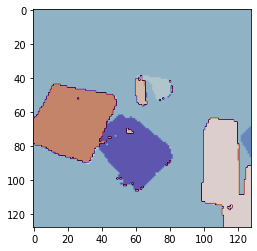

In [20]:
masks_t1, _, alive_t1 = TargetFunc.target_model.Comp(plateau[:,0])[:3]
vis_utils.imshow(masks_t1[:,None].argmax(-1), cmap='twilight', vmin=0, vmax=masks_t1.argmax(-1).amax()+1)

## Debug tracking with competition / pointers

In [39]:
TargetFunc.target_model.Comp.num_competition_rounds = 2
masks_t1, positions_t1, alive_t1, pointers_t1 = TargetFunc.target_model.Comp(
    plateau[:,0])[:4]
TargetFunc.target_model.Comp.num_competition_rounds = 0
masks_t2, positions_t2, alive_t2, pointers_t2 = TargetFunc.target_model.Comp(
    plateau[:,1], agents=positions_t1, alive=alive_t1, phenotypes=pointers_t1, compete=False)[:4]

TargetFunc.target_model.Comp.num_competition_rounds = 2
masks_t2_indep = TargetFunc.target_model.Comp(plateau[:,1], compete=True)[0]


OP = fprop.ObjectPointers().cuda()
positions_t2_reset, alive_t2_reset, fire_t2 = OP(masks_t2, alive_t2)
agents_map_t2_reset = competition.Competition.plot_agents(positions_t2_reset, alive_t2_reset, size=[128,128])


0 (tensor([ 0,  3,  8,  9, 11, 22, 24], device='cuda:0'),)
1 (tensor([ 0,  3,  8,  9, 11, 13, 20, 22, 24, 27], device='cuda:0'),)
0 (tensor([ 1,  4,  5, 12, 16, 22, 27], device='cuda:0'),)
1 (tensor([ 1,  4,  5,  7, 12, 16, 20, 22, 27], device='cuda:0'),)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


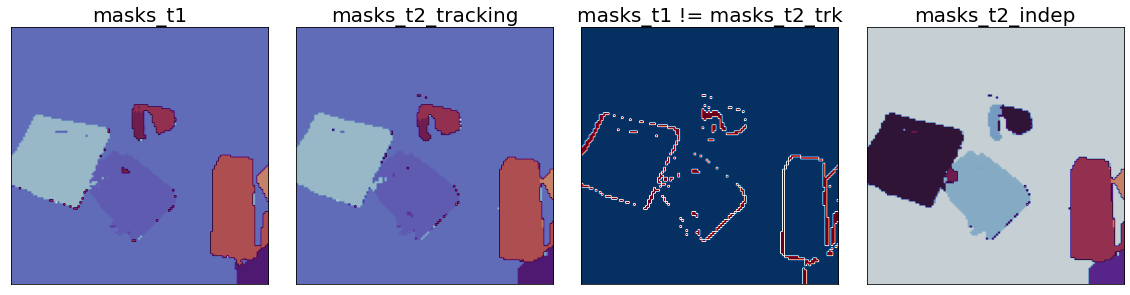

In [41]:
fig, axes = plt.subplots(1,4,figsize=(16,4))
vis_utils.imshow(masks_t1[:,None].argmax(-1), axes[0], cmap='twilight', vmin=-1, vmax=33)
vis_utils.imshow(masks_t2[:,None].argmax(-1), axes[1], cmap='twilight', vmin=-1, vmax=33)
vis_utils.imshow(masks_t1[:,None].argmax(-1) == masks_t2[:,None].argmax(-1), axes[2], cmap='RdBu', vmin=0, vmax=1)
vis_utils.imshow(masks_t2_indep[:,None].argmax(-1), axes[3], cmap='twilight', vmin=-1, vmax=33)

# vis_utils.imshow(agents_map_t2_reset[:,None], axes[3], cmap='twilight', vmin=-1, vmax=33)

# titles = ['masks_t1', 'masks_t2', 'masks_t1 == masks_t2', 'agents_t2_reset']
titles = ['masks_t1', 'masks_t2_tracking', 'masks_t1 != masks_t2_trk', 'masks_t2_indep']

for i,ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()
plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


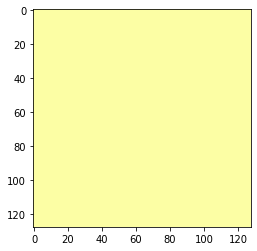

In [36]:
fire_norm = F.relu(fire_t2[0] - fire_t2[0].amax((-2,-1), True) + 1)
vis_utils.imshow(fire_norm[1, None], cmap='inferno', vmin=0, vmax=1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


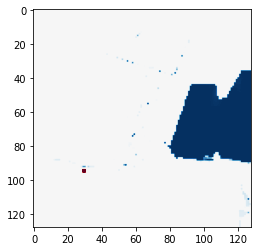

In [288]:
i = 10
vis_utils.imshow(masks_t2[:,None,...,i] - 2 * (agents_map_t2_reset[:,None] == i), cmap='RdBu', vmin=-1, vmax=1)
# vis_utils.imshow(fire_t2[0][i,None])

In [249]:
GF = fprop.GrassFire().cuda()
fire, borders = GF(masks_t2.argmax(-1)[:,None] == 0)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


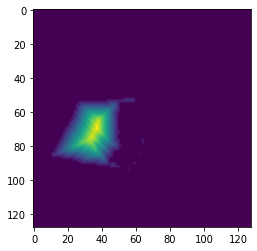

In [250]:
vis_utils.imshow(fire)

In [212]:
bounds, _ = fprop.get_mask_boundaries(masks_t2[:,None,...,1])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


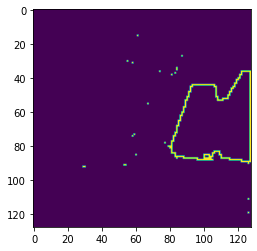

In [213]:
vis_utils.imshow(bounds)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


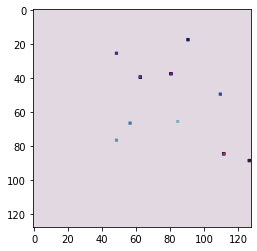

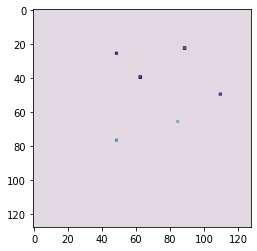

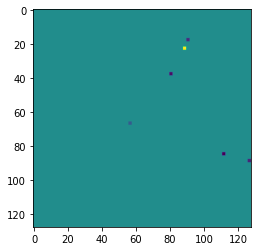

In [160]:
agents_map_t1 = competition.Competition.plot_agents(positions_t1, alive_t1, size=[128,128])
agents_map_t2 = competition.Competition.plot_agents(positions_t2, alive_t2, size=[128,128])
vis_utils.imshow(agents_map_t1[:,None], cmap='twilight', vmin=0, vmax=33)
vis_utils.imshow(agents_map_t2[:,None], cmap='twilight', vmin=0, vmax=33)
vis_utils.imshow(agents_map_t2[:,None] - agents_map_t1[:,None])


In [140]:
flateau2, phenos2 = competition.Competition.flatten_plateau_with_masks(
    plateau[:,1], masks2, alive2
)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


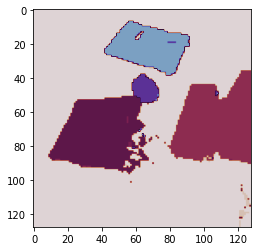

In [123]:
vis_utils.imshow(flateau2[:,None].argmax(-1), cmap='twilight', vmin=0, vmax=66)

In [124]:
OP = fprop.ObjectPointers().cuda()
pointers2reset, _ = OP(masks2_flat, alive2)
masks2_flat = TargetFunc.target_model.Comp(
    flateau2, agents=pointers2reset, alive=alive2, phenotypes=phenos2)[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


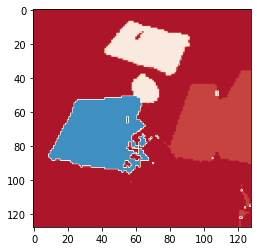

In [125]:
vis_utils.imshow(masks2_flat[:,None].argmax(-1), cmap='RdBu', vmin=0, vmax=31)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


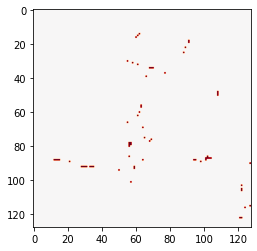

In [55]:
vis_utils.imshow(masks2[:,None].argmax(-1) != masks2_flat[:,None].argmax(-1), cmap='RdBu_r', vmin=-1, vmax=1)

In [42]:
agent_map = competition.Competition.plot_agents(positions[:,0], alive[:,0], size=[128,128])
agent_map2 = competition.Competition.plot_agents(positions2, alive2, size=[128,128])
agent_map2reset = competition.Competition.plot_agents(pointers2reset, alive2, size=[128,128])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


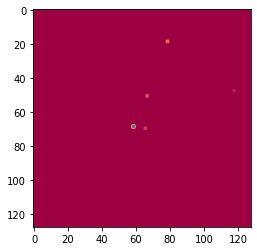

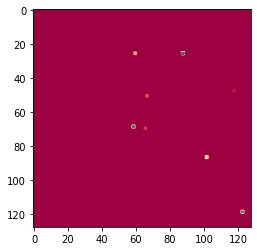

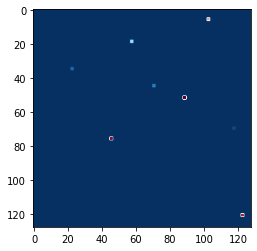

In [44]:
vis_utils.imshow(agent_map[:,None], cmap='Spectral', vmin=-1, vmax=agent_map.amax()+1)
vis_utils.imshow(agent_map2[:,None], cmap='Spectral', vmin=-1, vmax=agent_map.amax()+1)
vis_utils.imshow(agent_map2reset[:,None], cmap='RdBu_r', vmin=-1, vmax=agent_map.amax()+1)

In [75]:
positions[0,0,29], positions[0,0,29]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(tensor([-0.1811, -0.6063], device='cuda:0'),
 tensor([-0.1811, -0.6063], device='cuda:0'))

In [71]:
positions[0,0,26], positions[0,0,7]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(tensor([-0.3386,  0.1969], device='cuda:0'),
 tensor([-0.1969,  0.2598], device='cuda:0'))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


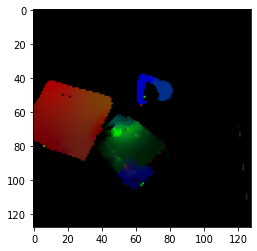

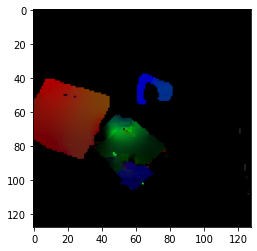

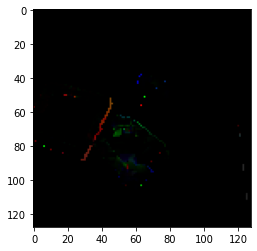

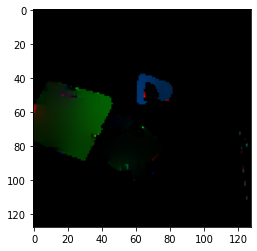

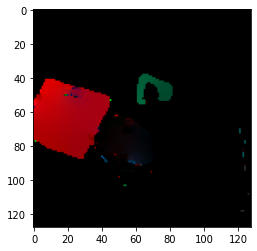

In [24]:
vis_utils.imshow(plateau[:,0,...,19:22].permute(0,3,1,2))
vis_utils.imshow(plateau[:,1,...,19:22].permute(0,3,1,2))
vis_utils.imshow(plateau[:,0,...,19:22].permute(0,3,1,2) - plateau[:,1,...,19:22].permute(0,3,1,2))

vis_utils.imshow(plateau_t1[:,...,19:22].permute(0,3,1,2))
vis_utils.imshow(plateau_t2[:,...,19:22].permute(0,3,1,2))

## Debug BorderOwnership RNN

In [56]:
BO = fprop.HarmonicPropagation(num_iters=10, 
                               initial_diffusion_iters=500,
                               diffusion_iters=10,
                               radius=5, 
                               contour_radius=11,
                               contour_iters=2,
                               downsample_factor=1,
                               motion_thresh=0.5,
                               boundary_thresh=0.1,
                               build_flow_target=True,
                               rescale_flow_target=True,
                               normalize_flow=False,
                               clamp_flow=True
).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


flow edges


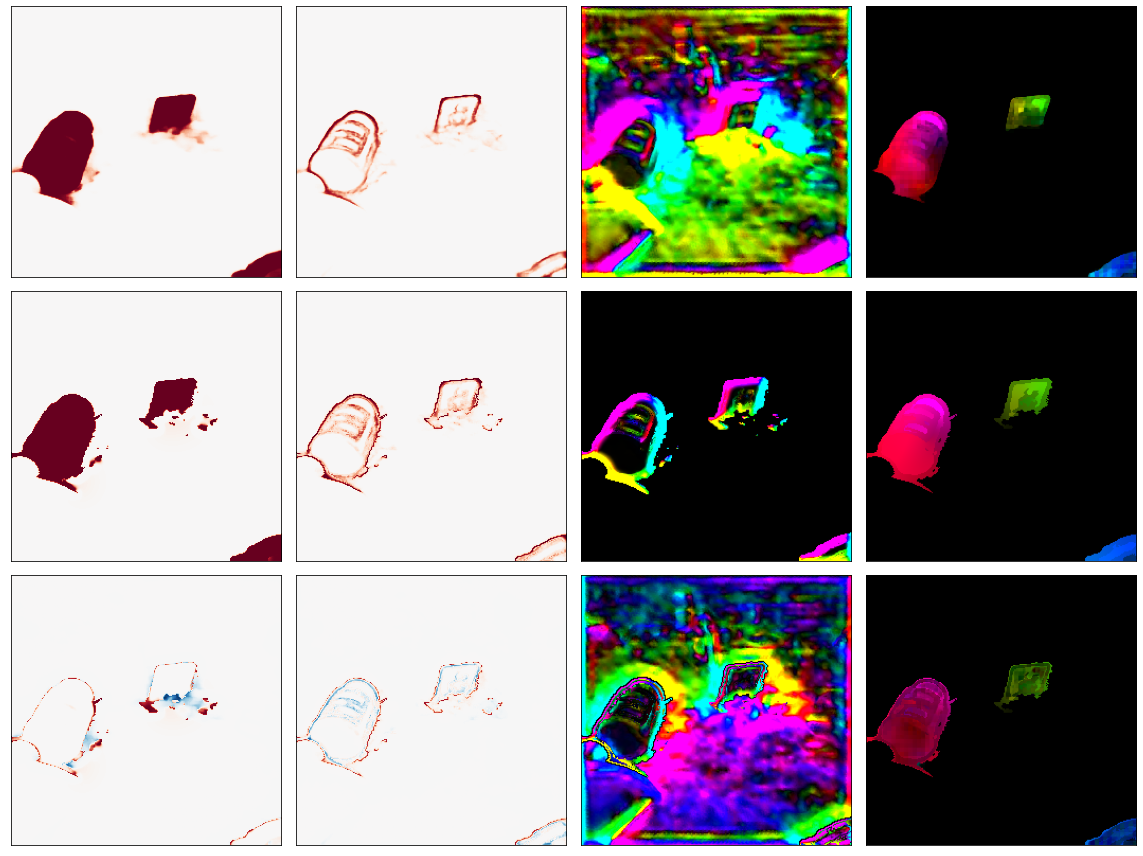

In [57]:
a0, b0, c0, f0 = [
    targets['motion'].detach(), targets['boundaries'].detach(), \
    targets['orientations'].detach(), targets['flow'].detach()]
# c0 = c0 * (b0 > 0.1).float()
a, b, c, f = BO(a0, b0, c0, flow=f0)
c = c

fig, axes = plt.subplots(3,4,figsize=(16,12))

plot_kwargs = {
    0: {'cmap': 'RdBu_r', 'vmin': -1, 'vmax': 1},
    1: {'cmap': 'RdBu_r', 'vmin': -1, 'vmax': 1},
    2: {},
    3: {}
}

for i,plot in enumerate((a0, b0, c0, f0)):
    if i == 1:
        plot = plot
    if i == 2:
        plot = data_utils.FlowToRgb(0.25)(plot)
    if i == 3:
        plot = data_utils.FlowToRgb(3.0)(plot)
    vis_utils.imshow(plot, axes[0,i], **plot_kwargs[i])
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
for i,plot in enumerate((a, b, c, f)):
    if i == 1:
        plot = plot
    if i == 2:
        plot = data_utils.FlowToRgb(0.25)(plot)
    if i == 3:
        plot = data_utils.FlowToRgb(5.0)(plot)        
    vis_utils.imshow(plot, axes[1,i], **plot_kwargs[i])
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    
for i,plot in enumerate((a-a0, b-b0, c-c0, f-f0)):
    if i == 1:
        plot = plot
    if i == 2:
        plot = data_utils.FlowToRgb(0.25)(plot) 
    if i == 3:
        plot = data_utils.FlowToRgb(5.0)(plot)        
    vis_utils.imshow(plot, axes[2,i], **plot_kwargs[i])
    axes[2,i].set_xticks([])
    axes[2,i].set_yticks([])
plt.tight_layout()
plt.show()


In [58]:
TargetFunc.target_model.FP.resolution = 3
TargetFunc.target_model.FP.motion_resolution = 3

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
kp_args = TargetFunc.target_model.FP(a, b, c, f)

motion resolution 3
static x motion torch.Size([1, 81, 256, 256])
updated with fire torch.Size([1, 121, 128, 128])
updated with boundaries torch.Size([1, 121, 128, 128])
updated with embedded flow


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


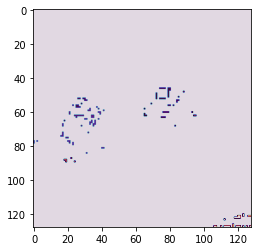

In [60]:
vis_utils.imshow(kp_args[0].argmax(1, True), cmap='twilight', vmin=0, vmax=kp_args[0].argmax(1).amax()+1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


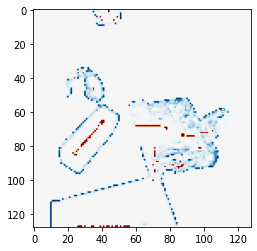

In [119]:
vis_utils.imshow(kp_args[2] - b[...,::2,::2], cmap='RdBu_r', vmin=-1, vmax=1)

In [120]:
TargetFunc.target_model.KP.num_iters = 200
plateau = TargetFunc.target_model.KP(*[x.detach() for x in kp_args])
am = (a > 0.5).float()
plateau = torch.cat([1-am[...,::2,::2], plateau * am[...,::2,::2]], 1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KP iters 200


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


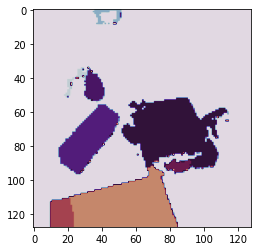

In [121]:
vis_utils.imshow(plateau.argmax(1, True), cmap='twilight', vmin=0, vmax=plateau.argmax(1).amax()+1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


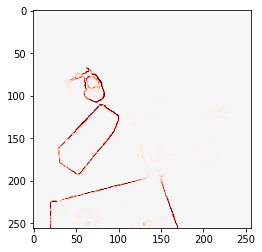

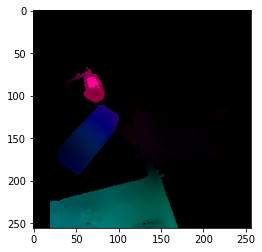

In [137]:
b0m = (b0 > 0.1).float()
c0mag = c0.square().sum(1, True).sqrt()
nb0 = b0m.sum((-2,-1), True).clamp(min=1)
f0_edges = kornia.filters.SpatialGradient(mode='sobel')(f).square().sum(2).sqrt().sum(1, True)
f0_edges_mean = (f0_edges * b0m).sum((-2,-1), True) / nb0
# vis_utils.imshow(b0m*(f0_edges - f0_edges_mean), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
vis_utils.imshow(b0*f0_edges, cmap='RdBu_r', vmin=-0.5 ,vmax=0.5)
vis_utils.imshow(data_utils.FlowToRgb(5.0)(f))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


motion resolution 3


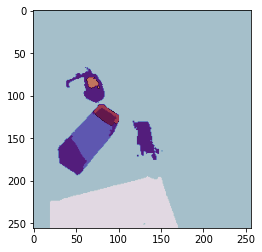

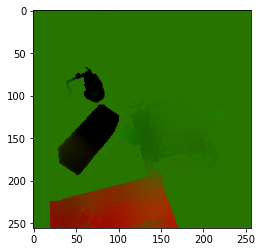

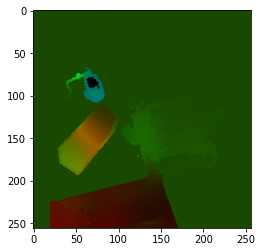

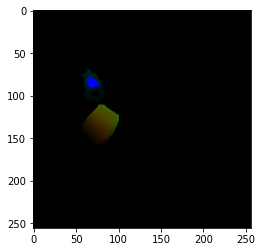

In [144]:
f_embed = TargetFunc.target_model.FP._embed_flow(f)
vis_utils.imshow(f_embed.argmax(1, True), cmap='twilight', vmin=0, vmax=10)
vis_utils.imshow(f_embed[:,0:3])
vis_utils.imshow(f_embed[:,3:6])
vis_utils.imshow(f_embed[:,6:9])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.7075416445732117 2.9443864822387695 -2.6002464294433594 4.393789291381836


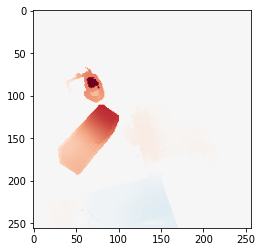

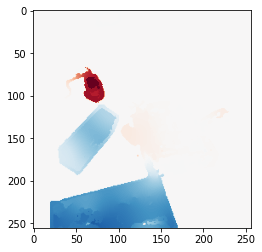

In [138]:
vis_utils.imshow(f[:,0:1], cmap='RdBu_r', vmin=-3.0, vmax=3.0)
vis_utils.imshow(f[:,1:2], cmap='RdBu_r', vmin=-3.0, vmax=3.0)

print(f[:,0:1].amin().item(), f[:,0:1].amax().item(), f[:,1:2].amin().item(), f[:,1:2].amax().item())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


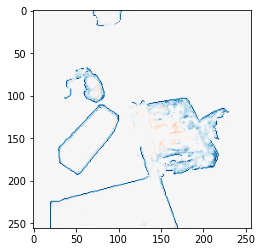

In [124]:
b_ext = BO.extend_contours(b, c0, radius=11)
vis_utils.imshow(b_ext * b0 - b, cmap='RdBu_r', vmin=-1, vmax=1)
# vis_utils.imshow(data_utils.FlowToRgb(0.25)(-b_ext) * b0)

In [97]:
fpred = targets['flow']
bm = (b0 > 0.1).float()
flow_diffuse_h = BO.diffusion((1-bm)*fpred[:,0:1], bm, c0,
                            num_iters=1000,
                            a_thresh=None, b_thresh=0.1,
                            with_flux=False)
flow_diffuse_w = BO.diffusion((1-bm)*fpred[:,1:2], bm, c0,
                              num_iters=1000,
                              a_thresh=None, b_thresh=0.1,
                              with_flux=False)
flow_diffuse = torch.cat([flow_diffuse_h, flow_diffuse_w], 1)
flow_diffuse = flow_diffuse*(1-bm) + fpred*bm

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


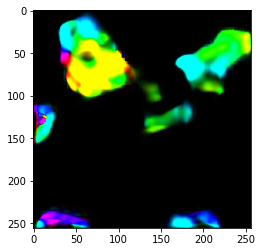

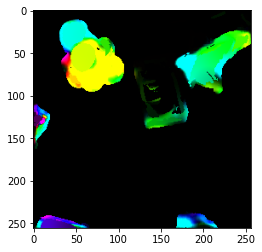

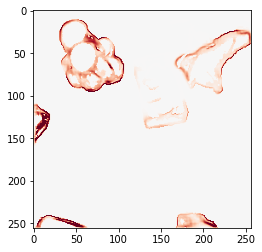

In [116]:
# vis_utils.imshow(fpred[:,0:1]*(1-bm), cmap='RdBu_r', vmin=-1, vmax=1)
# vis_utils.imshow(flow_diffuse, cmap='RdBu_r', vmin=-1, vmax=1)
flow_diffuse = BO.flow_diffusion_target(fpred.detach(), a, b0, 400)
am = (a > 0.5).float()
flow_edges = kornia.filters.SpatialGradient(mode='sobel')(fpred*a)
flow_edges = flow_edges.square().sum(2).sqrt().sum(1, True)

vis_utils.imshow(data_utils.FlowToRgb(1.)(fpred))
vis_utils.imshow(data_utils.FlowToRgb(1.)(flow_diffuse))
vis_utils.imshow(flow_edges*bm, cmap='RdBu_r', vmin=-1, vmax=1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


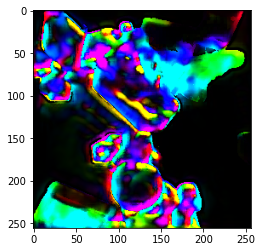

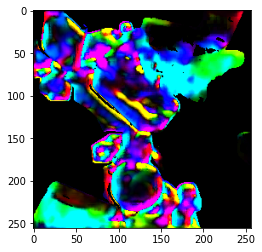

In [27]:
vis_utils.imshow(a * data_utils.FlowToRgb(1.0)(targets['flow']))
vis_utils.imshow((a>0.5).float() * data_utils.FlowToRgb(1.0)(targets['flow']))

In [ ]:
FP = fprop.FirePropagation().cuda()
MST = fprop.MotionSegmentTarget(downsample_factor=2, 
                                diffusion_params=None, 
                                fp_params={
                                    'num_iters': 2,
                                    'resolution': 4,
                                    'num_sample_points': 256
                                }
).cuda()
target = MST(None, a, b, c)
target.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


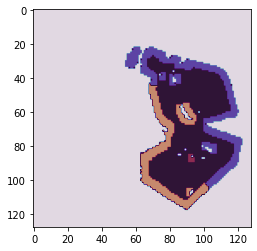

In [399]:
vis_utils.imshow(target[:,None], cmap='twilight', vmin=-1, vmax=target.amax().item()+1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


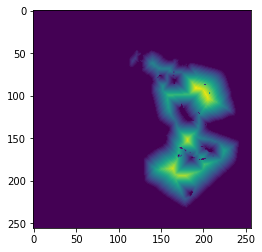

In [372]:
vis_utils.imshow(fire)

## Debug Flow

In [19]:
movi_dataset.T = 2
img1, img2, flow, segments = [x[None].cuda() for x in movi_dataset[ex]]
TargetFunc.return_intermediates = False
TargetFunc.target_model.target_type = 'motion'
TargetFunc.student_model_type = 'flow'
flow_target = TargetFunc(img1, img2)
print(flow_target.shape)
# flow_pred, _ = TargetFunc.get_flow_preds(TargetFunc.flow_model, img1, img2, iters=12)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


movie, frame b'2373' 12
run hp
torch.Size([1, 2, 256, 256])


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


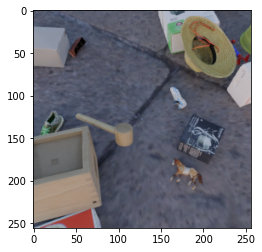

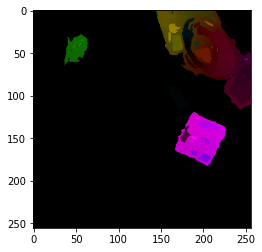

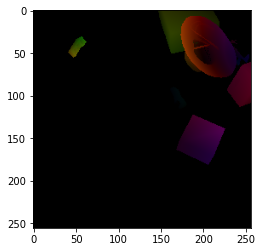

In [20]:
vis_utils.imshow(img1 / 255.)
vis_utils.imshow(data_utils.FlowToRgb(3.0)(flow_target))
vis_utils.imshow(data_utils.FlowToRgb(20.)(flow))

# Compute Adj from borders

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


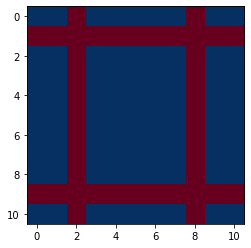

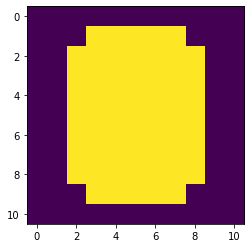

In [215]:
bounds = torch.zeros((11,11)).cuda().float()
bounds[:,[2,8]] = 1
bounds[[1,9],:] = 1
windows = fprop.get_adj_from_boundaries(bounds[None,None].detach(), radius=5, reshape=False)
vis_utils.imshow(bounds[None,None], cmap='RdBu_r', vmin=0, vmax=1)
# vis_utils.imshow(resize3(bounds[None,None]) > 0, cmap='RdBu_r', vmin=0, vmax=1)
vis_utils.imshow(windows[:,60,None])

In [197]:
windows.shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 121, 11, 11])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


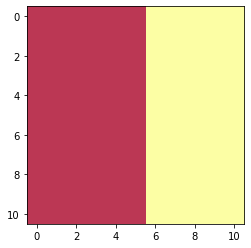

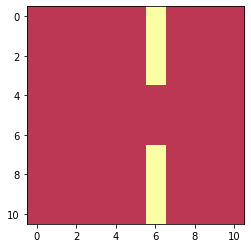

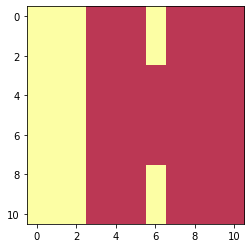

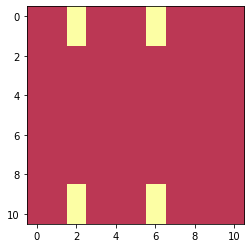

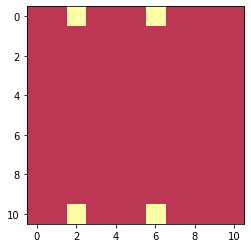

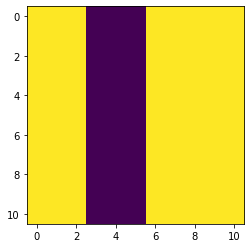

In [193]:
for i in range(windows.shape[-1]):
    w = windows[...,i]
    vis_utils.imshow(w[:,60:61].view(1,1,11,11), cmap='inferno', vmin=-1, vmax=1)
vis_utils.imshow(windows.amax(-1)[:,60:61])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


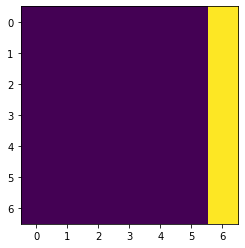

In [80]:
w = windows[...,-1][:,40:41]
# w[:,:,1,1] = -1
vis_utils.imshow(transforms.Resize([7,7], interpolation=transforms.InterpolationMode.BILINEAR)(w) > 0.99)


In [51]:
F.pad?

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
